In [1]:
import mlflow
from mlflow.entities import ViewType
import seaborn as sns
from IPython.display import Image, display
from PIL import Image
import matplotlib.pyplot as plt
import ast

In [ ]:
mlflow.get_registry_uri()

In [3]:
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]

sns.set_palette(five_thirty_eight)

## TORE Label Distribution with vs. without SMOTE (sampling strategy: not majority)

### Balancing all classes but the majority class

In [4]:

def getLabelDistribution(experiment):
    runs = mlflow.search_runs(
    experiment_ids=experiment.experiment_id,
    run_view_type=ViewType.ACTIVE_ONLY,
    output_format="pandas",
    )

    run = runs.iloc[0]
    
    labelDistributionOriginal_string = run["params.labelDistribution_0_Original"]
    labelDistributionSMOTE_string = run["params.labelDistribution_0_SMOTE"]

    dictStringOriginal = labelDistributionOriginal_string.split("(", 1)[1].rsplit(")", 1)[0]
    dictStringSMOTE = labelDistributionSMOTE_string.split("(", 1)[1].rsplit(")", 1)[0]

    labelDistributionOriginal_dict = ast.literal_eval(dictStringOriginal)
    labelDistributionSMOTE_dict = ast.literal_eval(dictStringSMOTE)

    keysOriginal = list(labelDistributionOriginal_dict.keys())
    valuesOriginal = list(labelDistributionOriginal_dict.values())
    keysSMOTE = list(labelDistributionSMOTE_dict.keys())
    valuesSMOTE = list(labelDistributionSMOTE_dict.values())
    
    return keysOriginal, valuesOriginal, keysSMOTE, valuesSMOTE

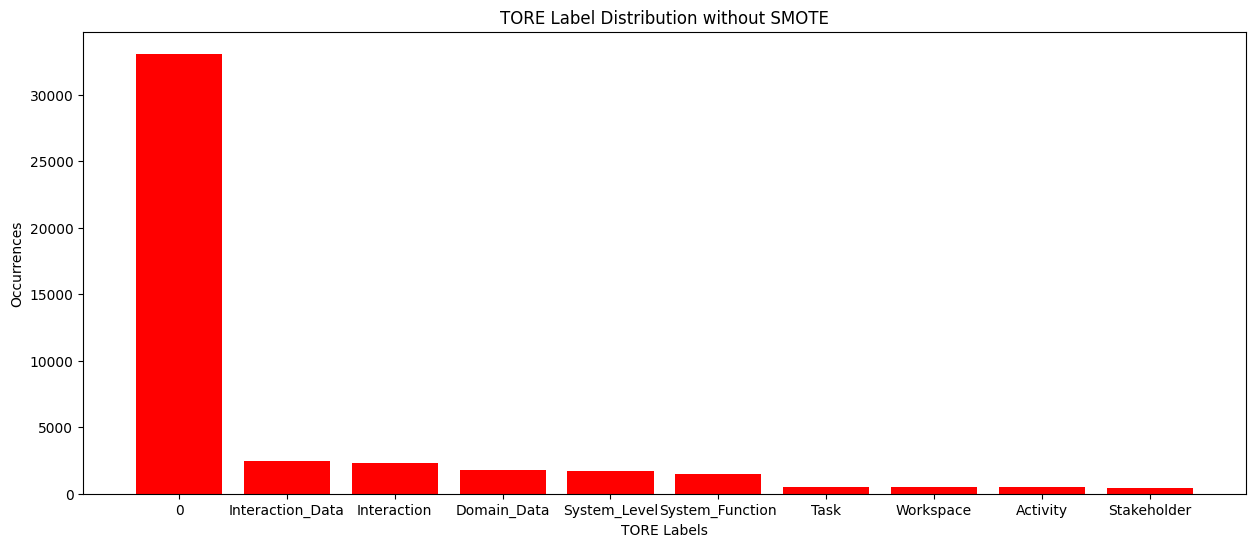

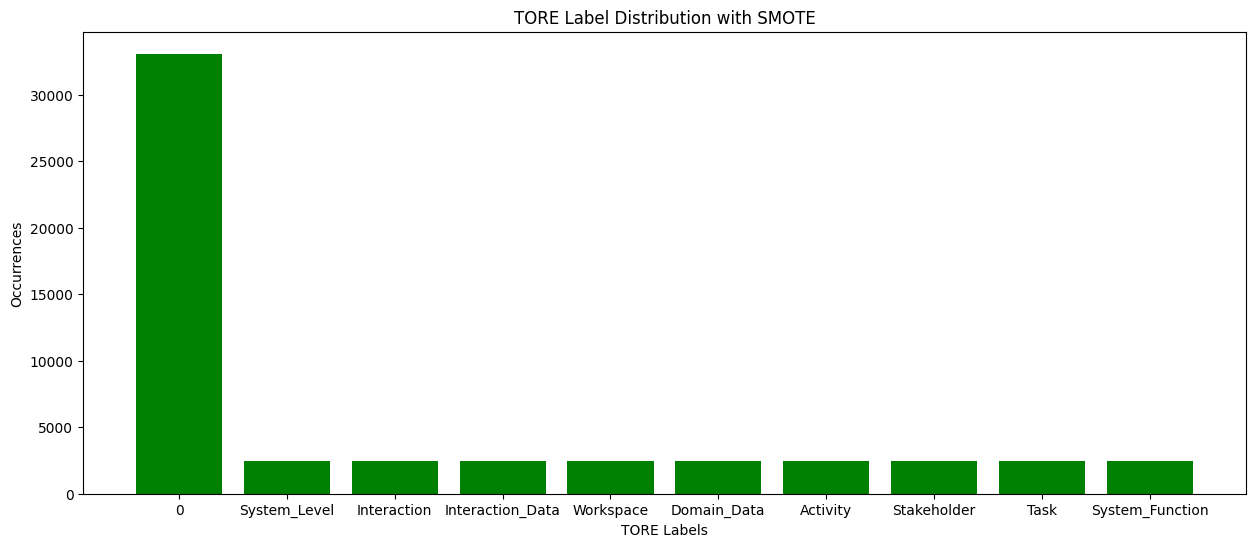

In [5]:
experimentSMOTE = mlflow.get_experiment_by_name("SMOTE_BERT_TORE_CATEGORIES")

keysOriginal, valuesOriginal, keysSMOTE, valuesSMOTE = getLabelDistribution(experimentSMOTE)

plt.figure(figsize=(15, 6))
plt.bar(keysOriginal, valuesOriginal, color= 'red')
plt.xlabel('TORE Labels')
plt.ylabel('Occurrences')
plt.title('TORE Label Distribution without SMOTE')
plt.show()

plt.figure(figsize=(15, 6))
plt.bar(keysSMOTE, valuesSMOTE, color= 'green')
plt.xlabel('TORE Labels')
plt.ylabel('Occurrences')
plt.title('TORE Label Distribution with SMOTE')
plt.show()

## Performance Comparison BERT with vs. without SMOTE  (sampling strategy: not majority)

In [6]:
def getBestResults(experiment):
    
    runs = mlflow.search_runs(
    experiment_ids=experiment.experiment_id,
    run_view_type=ViewType.ACTIVE_ONLY,
    output_format="pandas",
    )
    dataset_all_runs = runs[runs["params.experiment.dataset"].isin(["all"])]
    presentation_dataset = dataset_all_runs.copy()[
        [
            "params.bert.number_epochs",
            "params.bert.train_batch_size",
            "params.bert.learning_rate_bert",
            "params.bert.learning_rate_classifier",
            "params.bert.weight_decay",
            "params.bert.weighted_classes",
            "metrics.mean_recall",
            "metrics.mean_precision",
        ]
    ]
    presentation_dataset.rename(
        columns={
            "params.bert.number_epochs": "Number of Epochs",
            "params.bert.train_batch_size": "Train Batch Size",
            "params.bert.learning_rate_bert": "LR BERT",
            "params.bert.learning_rate_classifier": "LR Classifier",
            "params.bert.weighted_classes": "Weighted Classes",
            "params.bert.weight_decay": "Weight Decay",
            "metrics.mean_recall": "Mean Recall",
            "metrics.mean_precision": "Mean Precision",
        },
        inplace=True,
    )
    presentation_dataset["Number of Epochs"] = presentation_dataset[
        "Number of Epochs"
    ].astype("int32")
    presentation_dataset["Weight Decay"] = presentation_dataset[
        "Weight Decay"
    ].astype("float32")


    presentation_dataset["F1"] = (
        2
        * presentation_dataset["Mean Precision"]
        * presentation_dataset["Mean Recall"]
    ) / (
        presentation_dataset["Mean Precision"]
        + presentation_dataset["Mean Recall"]
    )
    presentation_dataset.sort_values(by="F1", ascending=False, inplace=True)
    presentation_dataset["Selected"] = False
    presentation_dataset.iloc[
        0, presentation_dataset.columns.get_loc("Selected")
    ] = True
    presentation_dataset.sort_values(by="F1", ascending=True, inplace=True)
    """
    fg = sns.relplot(
        data=presentation_dataset,
        x="Mean Precision",
        y="Mean Recall",
        col="Train Batch Size",
        row="LR BERT",
        hue="LR Classifier",
        size="Weight Decay",
        style="Selected",
        facet_kws={"margin_titles": True},
        height=2,
        kind="scatter",
    )
    fg.set(ylim=(0, 1))
    fg.set(xlim=(0, 1))
    """
    selected_run = dataset_all_runs.loc[presentation_dataset["Selected"] == True]
    run_id = selected_run["run_id"].values[0]
    path = mlflow.artifacts.download_artifacts(
        run_id=run_id, artifact_path="confusion_matrix.png"
    )

    bestResult = presentation_dataset.loc[presentation_dataset["Selected"] == True]
    
    return path, run_id, bestResult

## BERT First Stage Comparison with vs. without SMOTE (TORE Levels)

<function matplotlib.pyplot.show(close=None, block=None)>

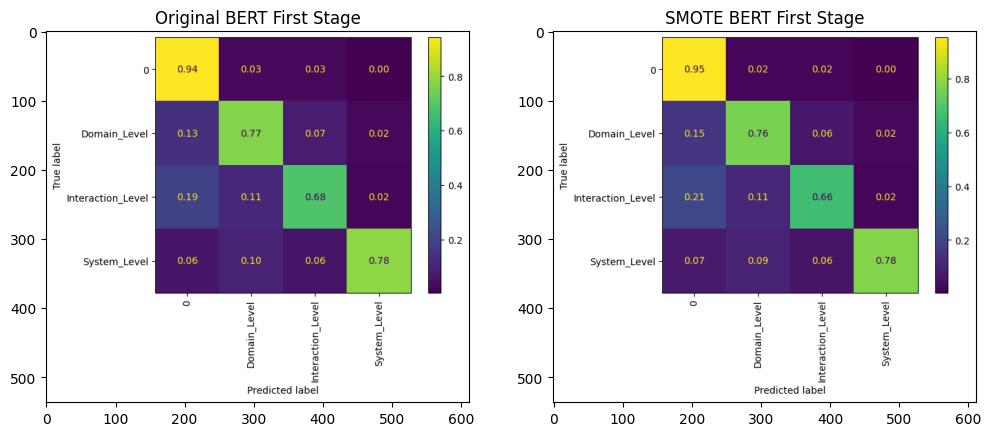

In [7]:
experimentSMOTE = mlflow.get_experiment_by_name("SMOTE_BERT_TORE_LEVELS")
experimentOriginal = mlflow.get_experiment_by_name("ORIGINAL_BERT_TORE_LEVELS")
pathSMOTE, runIdSMOTE, bestSMOTEResult = getBestResults(experimentSMOTE)
pathOriginal, runIdOriginal, bestOriginalResult = getBestResults(experimentOriginal)

original_image = Image.open(pathOriginal)
smote_image = Image.open(pathSMOTE)

plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title("Original BERT First Stage")

plt.subplot(1,2,2)
plt.imshow(smote_image)
plt.title("SMOTE BERT First Stage")

plt.show

In [8]:
#print("runIdSmote: ", runIdSmote)
print("bestSmote: ", bestSMOTEResult)

print("-----------------------------------------------------------------------------------------------")

#print("runIdOriginal: ", runIdOriginal)
print("bestOriginal: ", bestOriginalResult)

bestSmote:     Number of Epochs Train Batch Size LR BERT LR Classifier  Weight Decay  \
2                 8                8   3e-05        0.0005          0.01   

  Weighted Classes  Mean Recall  Mean Precision        F1  Selected  
2             True     0.788561        0.802581  0.795509      True  
-----------------------------------------------------------------------------------------------
bestOriginal:     Number of Epochs Train Batch Size LR BERT LR Classifier  Weight Decay  \
0                 8                8   3e-05        0.0005          0.01   

  Weighted Classes  Mean Recall  Mean Precision        F1  Selected  
0             True     0.794068        0.788163  0.791104      True  


## BERT E2E Comparison with vs. without SMOTE (TORE Categories)

<function matplotlib.pyplot.show(close=None, block=None)>

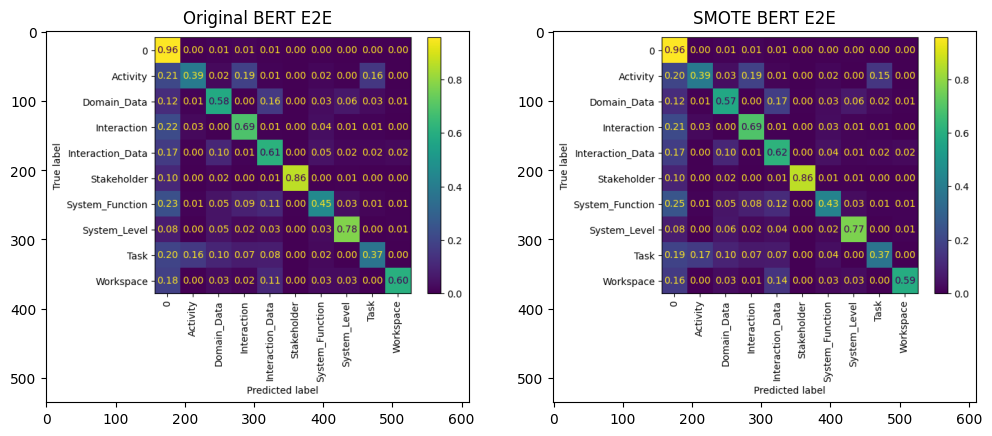

In [9]:
experimentSMOTE = mlflow.get_experiment_by_name("SMOTE_BERT_TORE_CATEGORIES")
experimentOriginal = mlflow.get_experiment_by_name("ORIGINAL_BERT_TORE_CATEGORIES")
pathSMOTE, runIdSMOTE, bestSMOTEResult = getBestResults(experimentSMOTE)
pathOriginal, runIdOriginal, bestOriginalResult = getBestResults(experimentOriginal)

original_image = Image.open(pathOriginal)
smote_image = Image.open(pathSMOTE)

plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title("Original BERT E2E")

plt.subplot(1,2,2)
plt.imshow(smote_image)
plt.title("SMOTE BERT E2E")

plt.show

In [10]:
#print("runIdSmote: ", runIdSmote)
print("bestSmote: ", bestSMOTEResult)

print("-----------------------------------------------------------------------------------------------")

#print("runIdOriginal: ", runIdOriginal)
print("bestOriginal: ", bestOriginalResult)

bestSmote:     Number of Epochs Train Batch Size LR BERT LR Classifier  Weight Decay  \
2                 8                8   6e-05           0.1          0.01   

  Weighted Classes  Mean Recall  Mean Precision        F1  Selected  
2            False     0.626061        0.655302  0.640348      True  
-----------------------------------------------------------------------------------------------
bestOriginal:     Number of Epochs Train Batch Size LR BERT LR Classifier  Weight Decay  \
0                 8                8   6e-05           0.1          0.01   

  Weighted Classes  Mean Recall  Mean Precision        F1  Selected  
0            False     0.630657        0.659187  0.644606      True  


## TORE Label Distribution with vs. without SMOTE (sampling strategy: minority)

### Balancing only the minority class

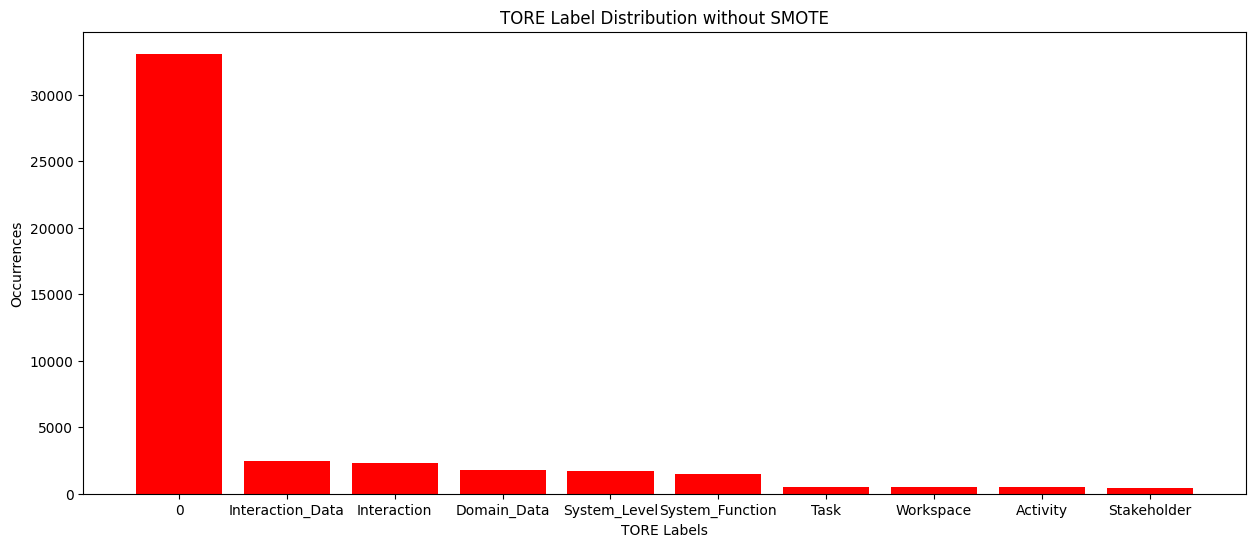

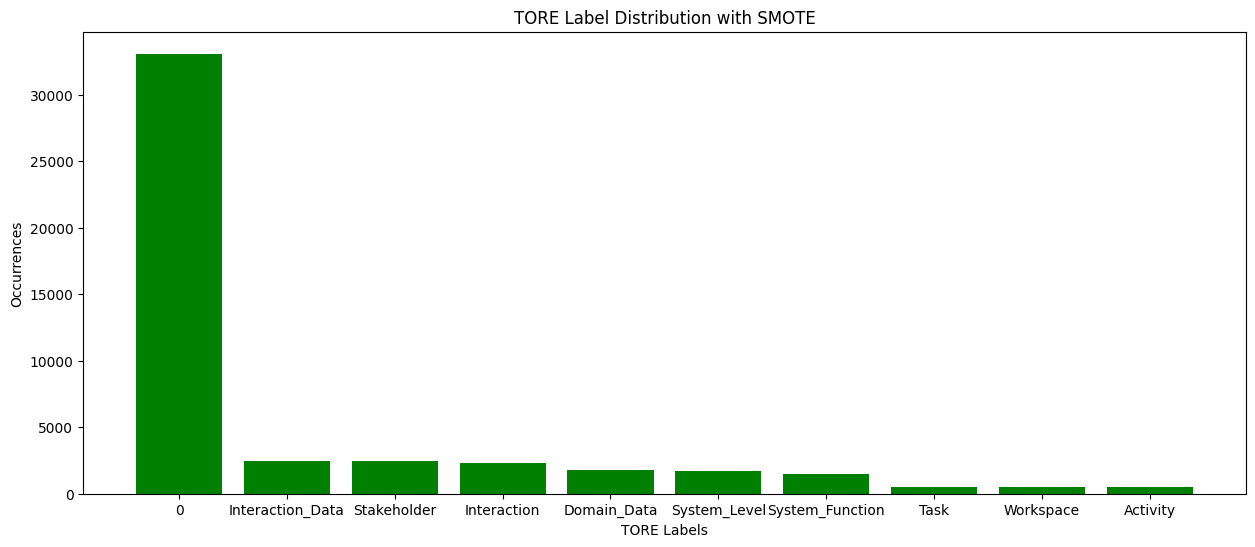

In [11]:
experimentSMOTE = mlflow.get_experiment_by_name("SMOTE_BERT_ONLY_MINORITY_TORE_CATEGORIES")

keysOriginal, valuesOriginal, keysSMOTE, valuesSMOTE = getLabelDistribution(experimentSMOTE)

plt.figure(figsize=(15, 6))
plt.bar(keysOriginal, valuesOriginal, color= 'red')
plt.xlabel('TORE Labels')
plt.ylabel('Occurrences')
plt.title('TORE Label Distribution without SMOTE')
plt.show()

plt.figure(figsize=(15, 6))
plt.bar(keysSMOTE, valuesSMOTE, color= 'green')
plt.xlabel('TORE Labels')
plt.ylabel('Occurrences')
plt.title('TORE Label Distribution with SMOTE')
plt.show()

## Performance Comparison BERT with vs. without SMOTE  (sampling strategy: minority)

## BERT E2E Comparison with vs. without SMOTE (TORE Categories)

<function matplotlib.pyplot.show(close=None, block=None)>

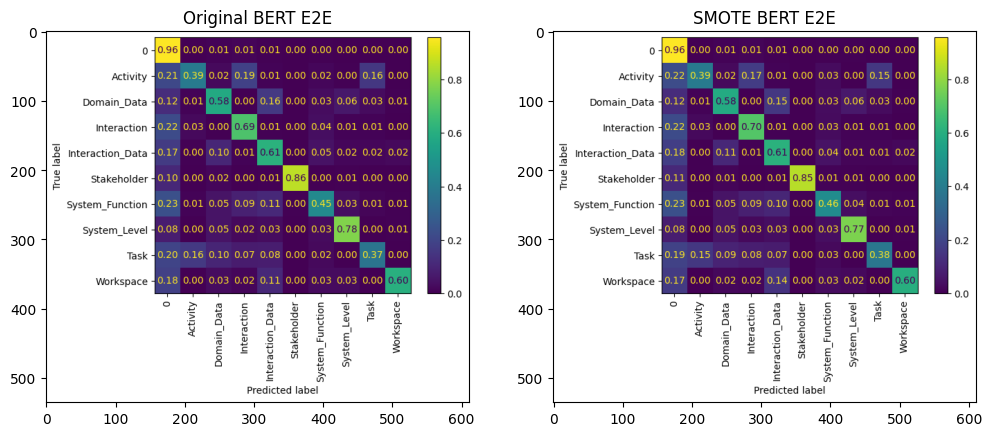

In [12]:
experimentSMOTE = mlflow.get_experiment_by_name("SMOTE_BERT_ONLY_MINORITY_TORE_CATEGORIES")
experimentOriginal = mlflow.get_experiment_by_name("ORIGINAL_BERT_TORE_CATEGORIES")
pathSMOTE, runIdSMOTE, bestSMOTEResult = getBestResults(experimentSMOTE)
pathOriginal, runIdOriginal, bestOriginalResult = getBestResults(experimentOriginal)

original_image = Image.open(pathOriginal)
smote_image = Image.open(pathSMOTE)

plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title("Original BERT E2E")

plt.subplot(1,2,2)
plt.imshow(smote_image)
plt.title("SMOTE BERT E2E")

plt.show

In [13]:
#print("runIdSmote: ", runIdSmote)
print("bestSmote: ", bestSMOTEResult)

print("-----------------------------------------------------------------------------------------------")

#print("runIdOriginal: ", runIdOriginal)
print("bestOriginal: ", bestOriginalResult)

bestSmote:     Number of Epochs Train Batch Size LR BERT LR Classifier  Weight Decay  \
0                 8                8   6e-05           0.1          0.01   

  Weighted Classes  Mean Recall  Mean Precision        F1  Selected  
0            False     0.631941        0.662056  0.646648      True  
-----------------------------------------------------------------------------------------------
bestOriginal:     Number of Epochs Train Batch Size LR BERT LR Classifier  Weight Decay  \
0                 8                8   6e-05           0.1          0.01   

  Weighted Classes  Mean Recall  Mean Precision        F1  Selected  
0            False     0.630657        0.659187  0.644606      True  


## TORE Label Distribution with vs. without SMOTE (sampling strategy: to average)

### Balancing only the classes, which occurrences are lower than the average occurrence over all classes. The number of occurrences from these minority classes is increased to the average number of occurrences over all classes.

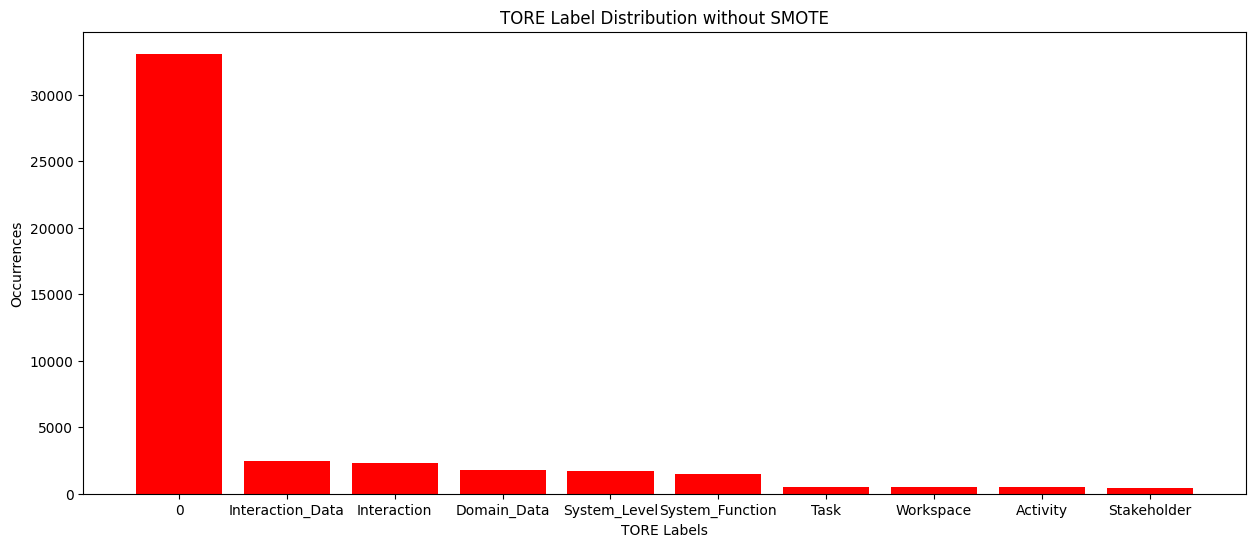

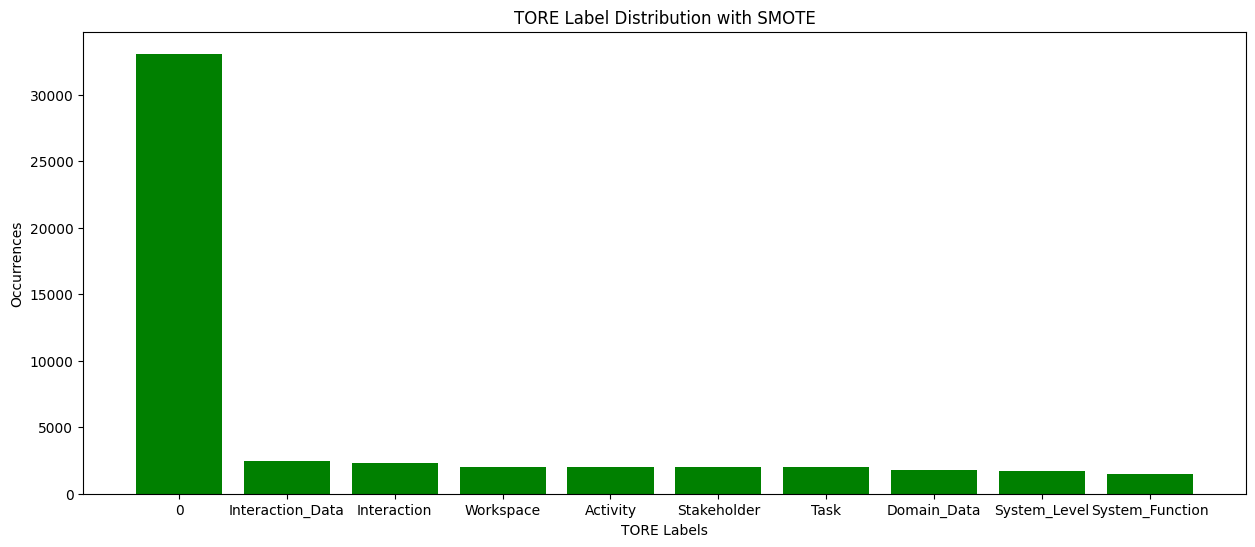

In [14]:
experimentSMOTE = mlflow.get_experiment_by_name("SMOTE_BERT_TORE_CATEGORIES_AVERAGE")

keysOriginal, valuesOriginal, keysSMOTE, valuesSMOTE = getLabelDistribution(experimentSMOTE)

plt.figure(figsize=(15, 6))
plt.bar(keysOriginal, valuesOriginal, color= 'red')
plt.xlabel('TORE Labels')
plt.ylabel('Occurrences')
plt.title('TORE Label Distribution without SMOTE')
plt.show()

plt.figure(figsize=(15, 6))
plt.bar(keysSMOTE, valuesSMOTE, color= 'green')
plt.xlabel('TORE Labels')
plt.ylabel('Occurrences')
plt.title('TORE Label Distribution with SMOTE')
plt.show()

## Performance Comparison BERT with vs. without SMOTE  (sampling strategy: to average)

## BERT E2E Comparison with vs. without SMOTE (TORE Categories)

<function matplotlib.pyplot.show(close=None, block=None)>

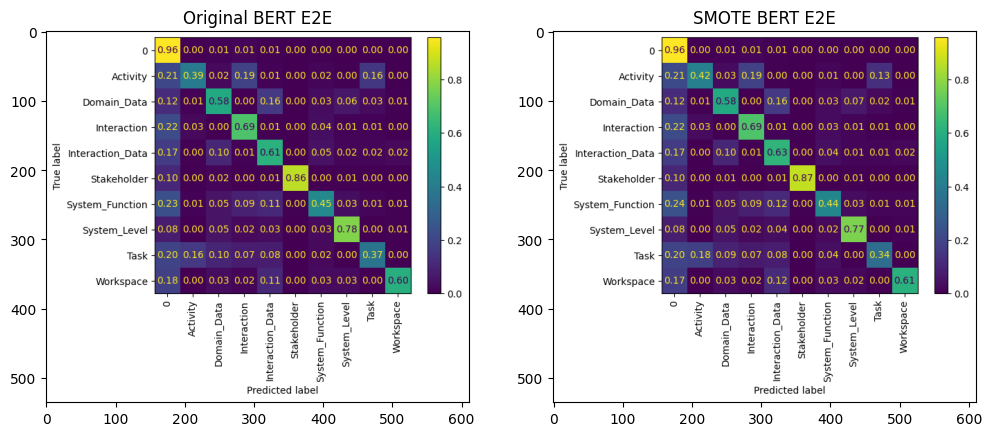

In [15]:
experimentSMOTE = mlflow.get_experiment_by_name("SMOTE_BERT_TORE_CATEGORIES_AVERAGE")
experimentOriginal = mlflow.get_experiment_by_name("ORIGINAL_BERT_TORE_CATEGORIES")
pathSMOTE, runIdSMOTE, bestSMOTEResult = getBestResults(experimentSMOTE)
pathOriginal, runIdOriginal, bestOriginalResult = getBestResults(experimentOriginal)

original_image = Image.open(pathOriginal)
smote_image = Image.open(pathSMOTE)

plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title("Original BERT E2E")

plt.subplot(1,2,2)
plt.imshow(smote_image)
plt.title("SMOTE BERT E2E")

plt.show

In [16]:
#print("runIdSmote: ", runIdSmote)
print("bestSmote: ", bestSMOTEResult)

print("-----------------------------------------------------------------------------------------------")

#print("runIdOriginal: ", runIdOriginal)
print("bestOriginal: ", bestOriginalResult)

bestSmote:     Number of Epochs Train Batch Size LR BERT LR Classifier  Weight Decay  \
1                 8                8   6e-05           0.1          0.01   

  Weighted Classes  Mean Recall  Mean Precision        F1  Selected  
1            False      0.63121        0.661214  0.645864      True  
-----------------------------------------------------------------------------------------------
bestOriginal:     Number of Epochs Train Batch Size LR BERT LR Classifier  Weight Decay  \
0                 8                8   6e-05           0.1          0.01   

  Weighted Classes  Mean Recall  Mean Precision        F1  Selected  
0            False     0.630657        0.659187  0.644606      True  
